# NYSE FANG+ index 週足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'NYFANG'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='5y', interval='1wk')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y =  datetime.timedelta(days=365 * 3)
df = df0[df0.index >= dt_last - tdelta_3y]

## Moving Median

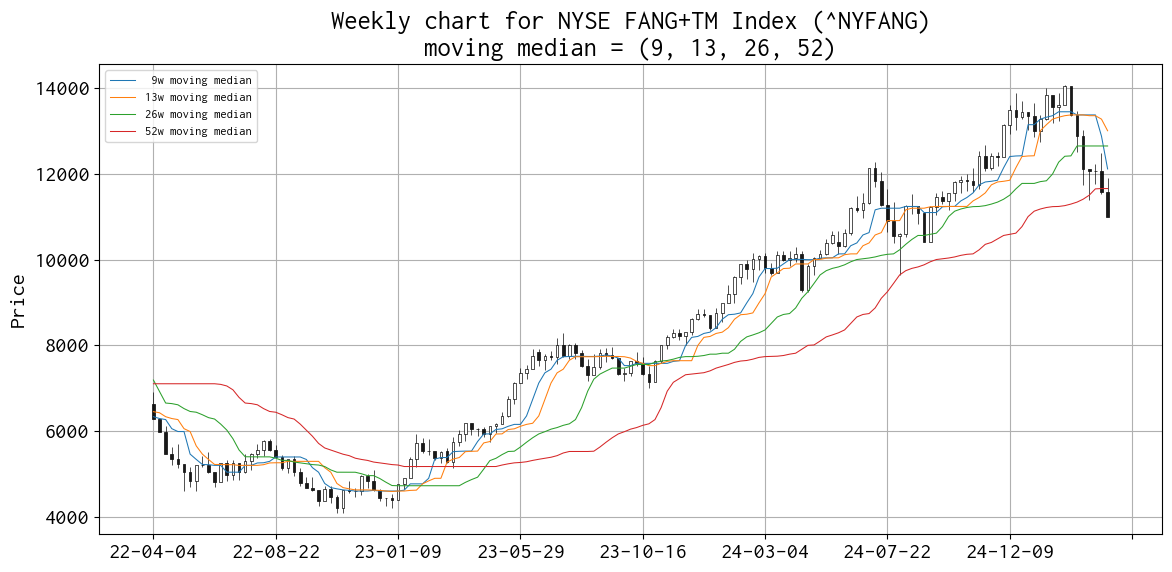

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm09 = df0['Close'].rolling(9).median()
mm13 = df0['Close'].rolling(13).median()
mm26 = df0['Close'].rolling(26).median()
mm52 = df0['Close'].rolling(52).median()

apds  = [
    mpf.make_addplot(mm09[df.index], width=0.75, label=' 9w moving median', ax=ax),
    mpf.make_addplot(mm13[df.index], width=0.75, label='13w moving median', ax=ax),
    mpf.make_addplot(mm26[df.index], width=0.75, label='26w moving median', ax=ax),
    mpf.make_addplot(mm52[df.index], width=0.75, label='52w moving median', ax=ax),
]   

mpf.plot(df, type='candle', style='default', datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax)

ax.set_title('Weekly chart for %s (%s)\nmoving median = (9, 13, 26, 52)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('report_weekly_chart_median_%s.png' % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-24 00:00:00-04:00,12055.480469,12488.900391,11524.830078,11566.830078,0,0.0,0.0
2025-03-31 00:00:00-04:00,11566.830078,11888.309570,10981.467773,10997.455078,0,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-03-24 00:00:00-04:00    11566.830078
2025-03-31 00:00:00-04:00    10997.455078
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-03-24 00:00:00-04:00        NaN
2025-03-31 00:00:00-04:00   -569.375
Name: Close, dtype: float64

In [9]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-31 00:00:00-04:00   -569.375
dtype: float64

In [10]:
df['Close'].rolling(9).median().tail()

Date
2025-03-03 00:00:00-05:00    13366.769531
2025-03-10 00:00:00-04:00    13366.769531
2025-03-17 00:00:00-04:00    13366.769531
2025-03-24 00:00:00-04:00    12871.910156
2025-03-31 00:00:00-04:00    12109.650391
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(13).median().tail()

Date
2025-03-03 00:00:00-05:00    13366.769531
2025-03-10 00:00:00-04:00    13348.889648
2025-03-17 00:00:00-04:00    13348.889648
2025-03-24 00:00:00-04:00    13268.490234
2025-03-31 00:00:00-04:00    12998.370117
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).median().tail()

Date
2025-03-03 00:00:00-05:00    12643.984863
2025-03-10 00:00:00-04:00    12643.984863
2025-03-17 00:00:00-04:00    12643.984863
2025-03-24 00:00:00-04:00    12643.984863
2025-03-31 00:00:00-04:00    12643.984863
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).median().tail()

Date
2025-03-03 00:00:00-05:00    11405.005371
2025-03-10 00:00:00-04:00    11498.479980
2025-03-17 00:00:00-04:00    11645.584961
2025-03-24 00:00:00-04:00    11653.055176
2025-03-31 00:00:00-04:00    11653.055176
Name: Close, dtype: float64

## Robust Bollinger bands

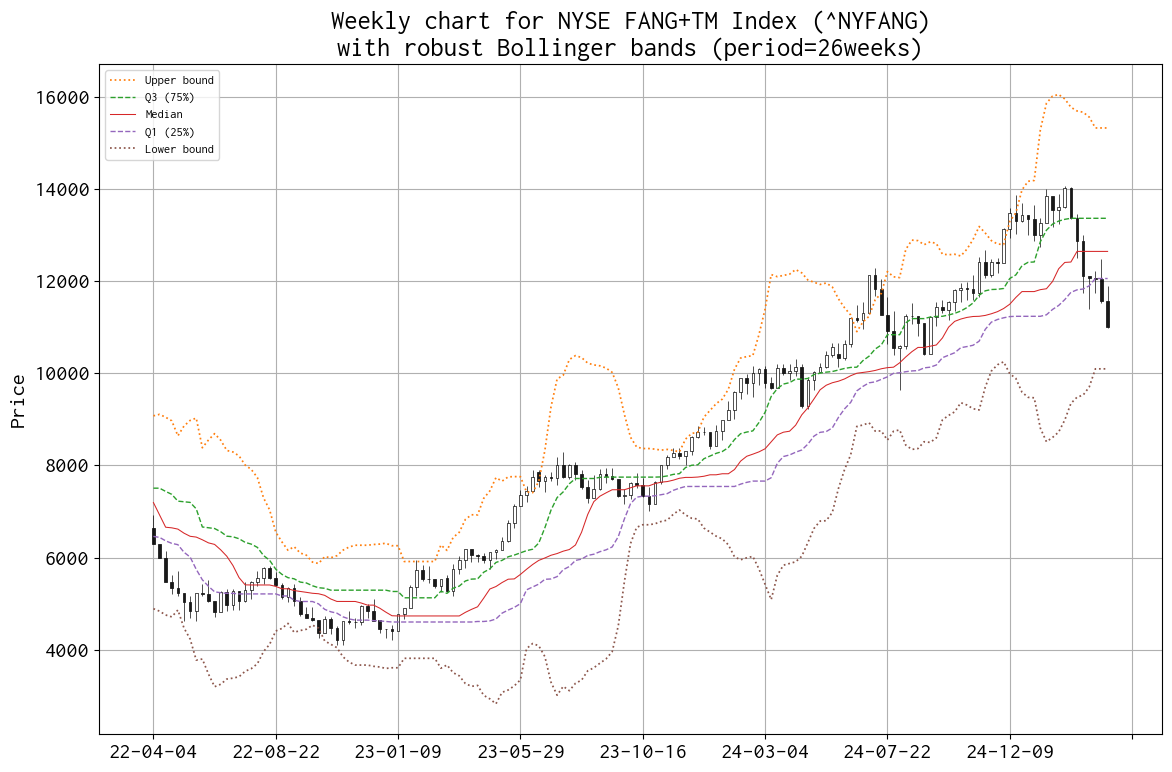

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

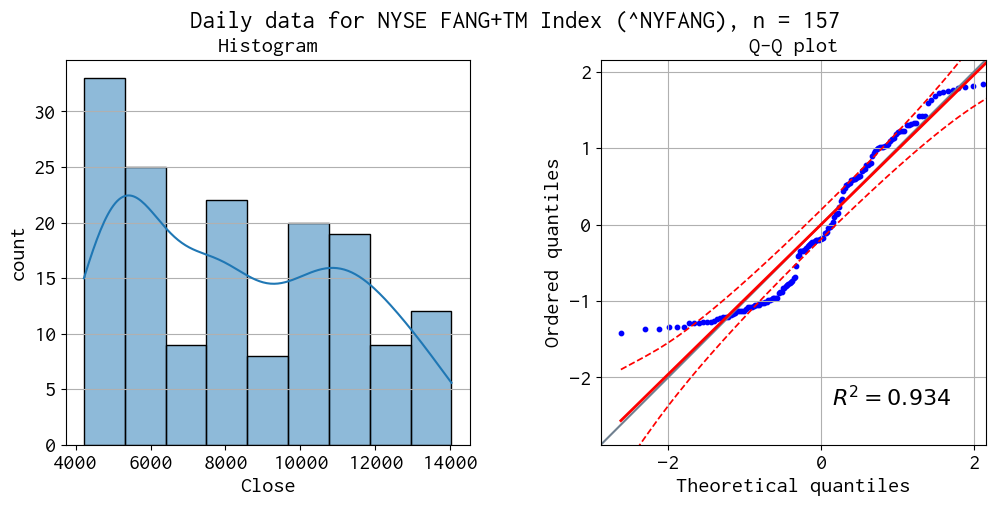

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_weekly_histogram_qqplot_%s.png' % code)
plt.show()